# Ejemplo diseño pasa banda filtro RDS

## Introducción

- https://www.advantest.com/documents/11348/7898f05e-0a52-4e68-9221-3b8b75595436

<img src="ejemplo_rds/espectro_rds.gif"/>


## Plantilla

<img src="ejemplo_rds/pasa_banda_plantilla.jpg"/>

$f_0 = 57KHz$

$B = 1187.5Hz$

$\alpha_{max} = 1dB$

$\alpha_{min_1} = 25dB$

$\alpha_{min_2} = 25dB$

$f_{s1} = 53KHz$

$f_{s2} = 62KHz$


## Requisito de filtro

- Filtro de máxima planicidad pasa banda
- Implementar con Ackerberg Mossberg

In [1]:
import scipy.signal as sig
import matplotlib.pyplot as plt
from splane import pzmap, grpDelay, bodePlot, convert2SOS
import numpy as np
import math as m

### Cálculo de Q

In [2]:
f_rds = 57e3  # Hz
B = 1187.5 # Hz
Q = f_rds / B

fs1 = 53e3  # Hz
fs2 = 62e3  # Hz

print('Q: {}'.format(Q))

Q: 48.0


### Calculo de las frecuencias de plantilla BP y LP

In [3]:
# Calculo de frecuencias apropiado!
np.roots([1, B, -f_rds*f_rds])

array([-57596.84236403,  56409.34236403])

In [4]:
# Calculo de frecuencias en la banda de paso (no apropiado, solo aproximacion por alto Q)
fp1 = f_rds - B/2
fp2 = f_rds + B / 2
f0 = np.sqrt(fp1 * fp2)

print('f1: {}, f2: {}, f0: {}'.format(fp1, fp2, f0))

f1: 56406.25, f2: 57593.75, f0: 56996.907468190766


In [5]:
# Calculo de las w
w0 = 2 * np.pi * f0
wp1 = 2 * np.pi * fp1
wp2 = 2 * np.pi * fp2

# Normalizo respecto de w0
wp1 = wp1 / w0
wp2 = wp2 / w0

print('wp1: {}, wp2: {}'.format(wp1, wp2))

wp1: 0.9896370260347827, wp2: 1.010471489740778


In [6]:
def hp2lp(wp, w0, Q):
    return Q * (wp**2 - w0**2) / wp

In [7]:
# Calculo de las W
Wp1 = hp2lp(wp1, 1, Q)
Wp2 = hp2lp(wp2, 1, Q)

print('Wp1: {}, Wp2: {}'.format(Wp1, Wp2))

Wp1: -1.0000542578877822, Wp2: 1.000054257887773


In [8]:
# Calculo el valor de Ws1 y Ws2
ws1 = 2 * np.pi * fs1
ws2 = 2 * np.pi * fs2
ws1 = ws1 / w0
ws2 = ws2 / w0


Ws1 = hp2lp(ws1, 1, Q)
Ws2 = hp2lp(ws2, 1, Q)

print('Ws1: {}, Ws2: {}'.format(Ws1, Ws2))

Ws1: -6.98584016333821, Ws2: 8.086721108777638


### Calculo de N y $\epsilon$

In [9]:
alpha_max = 1   # dB
alpha_min = 25  # dB


epsilon = m.sqrt(m.pow(10, 0.1 * alpha_max) - 1)
Ns1 = m.log10((m.pow(10, alpha_min * 0.1) - 1) / (m.pow(10, alpha_max * 0.1) - 1)) / (2 * m.log10(abs(Ws1)))
Ns2 = m.log10((m.pow(10, alpha_min * 0.1) - 1) / (m.pow(10, alpha_max * 0.1) - 1)) / (2 * m.log10(abs(Ws2)))

print('Ns1: {}, Ns2: {}'.format(Ns1, Ns2))

N = Ns1 if Ns1 > Ns2 else Ns2

print('epsilon: {}, N: {}, N_ent: {}'.format(epsilon, N, m.ceil(N)))

N = m.ceil(N)

Ns1: 1.82739969549721, Ns2: 1.699462092899426
epsilon: 0.5088471399095875, N: 1.82739969549721, N_ent: 2


### Calculo de w de Butterworth

In [10]:
N_omega_2 = 1 / m.sqrt(epsilon) # Escala por W_butterworth

print('N_omega_2: {}'.format(N_omega_2))

N_omega_2: 1.4018654458828321


### Cálculo de función transferencia prototipo pasa bajos

TransferFunctionContinuous(
array([1.]),
array([1.        , 1.41421356, 1.        ]),
dt: None
)
Polos:  [-0.70710678+0.70710678j -0.70710678-0.70710678j]
Ceros:  []


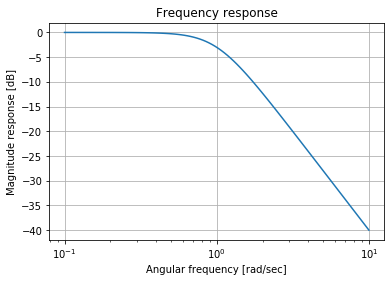

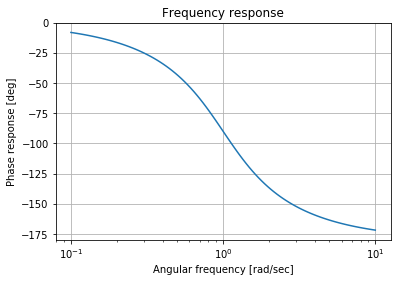

In [11]:
D_lp_butter = [1, m.sqrt(2), 1]
N_lp_butter = [1]
H_lp_butter = sig.TransferFunction(N_lp_butter, D_lp_butter)
print(H_lp_butter)
print('Polos: ', H_lp_butter.poles)
print('Ceros: ', H_lp_butter.zeros)
bodePlot(H_lp_butter)


0 zeros: []
2 poles: [-0.70710678+0.70710678j -0.70710678-0.70710678j]
gain: 1.0


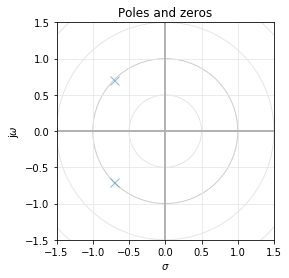

In [12]:
pzmap(H_lp_butter)

### Conversion a pasa banda

In [13]:
a = 1
b = N_omega_2 / (Q * m.sqrt(2)/2)
c = 2 + N_omega_2**2 / Q**2
d = N_omega_2 / (Q * m.sqrt(2)/2)
e = 1
k = N_omega_2**2 / Q**2

print('a: {}, b: {}, c: {}, d: {}, e: {}, k: {}'.format(a, b, c, d, e, k))


a: 1, b: 0.041302856795618896, c: 2.0008529629897396, d: 0.041302856795618896, e: 1, k: 0.0008529629897397013


TransferFunctionContinuous(
array([0.00085296, 0.        , 0.        ]),
array([1.        , 0.04130286, 2.00085296, 0.04130286, 1.        ]),
dt: None
)
Poles: [-0.01043233+1.01032572j -0.01043233-1.01032572j -0.01021909+0.98967429j
 -0.01021909-0.98967429j]
Zeros: [0. 0.]


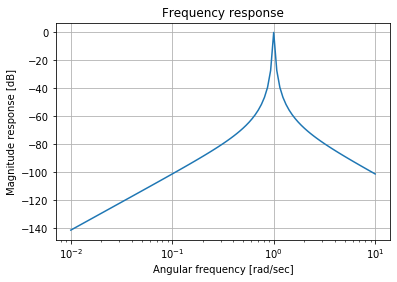

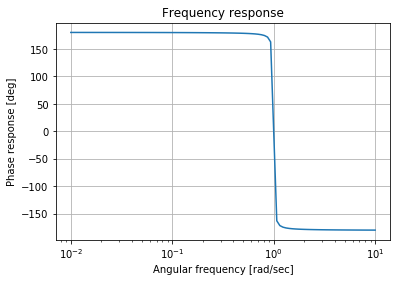

In [14]:
N_bp = [k, 0, 0]
D_bp = [a, b, c, d, e]

H_bp = sig.TransferFunction(N_bp, D_bp)

print(H_bp)
print('Poles:',H_bp.poles)
print('Zeros:', H_bp.zeros)
bodePlot(H_bp)

2 zeros: [0. 0.]
4 poles: [-0.01043233+1.01032572j -0.01043233-1.01032572j -0.01021909+0.98967429j
 -0.01021909-0.98967429j]
gain: 0.0008529629897397013


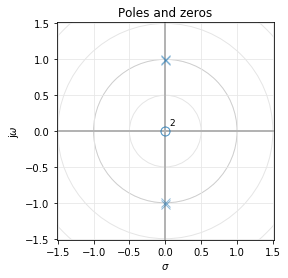

In [15]:
pzmap(H_bp)

In [16]:
print([1, 2*0.0104, np.abs(0.0104+1.0103j)**2])
print([1, 2*0.0102, np.abs(0.0102+0.9897j)**2])

[1, 0.0208, 1.02081425]
[1, 0.0204, 0.97961013]


In [17]:
0.0208*0.0204

0.00042432

In [18]:
np.convolve([1, -0.01043233+1.01032572j], [1, -0.01043233-1.01032572j])


array([ 1.        +0.j, -0.02086466+0.j,  1.02086689+0.j])

In [19]:
np.convolve([1, -0.01021909+0.98967429j], [1, -0.01021909-0.98967429j])

array([ 1.        +0.j, -0.02043818+0.j,  0.97955963+0.j])

In [20]:
np.roots([1/N_omega_2**2, m.sqrt(2)/N_omega_2, 1])

array([-0.99126856+0.99126856j, -0.99126856-0.99126856j])

In [21]:
np.roots([1, -(-0.99126856+0.99126856j)/Q, 1])

array([-0.01043233+1.01032572j, -0.01021909-0.98967429j])

In [22]:
np.roots([1, -(-0.99126856-0.99126856j)/Q, 1])

array([-0.01043233-1.01032572j, -0.01021909+0.98967429j])

In [23]:
L1 = 1 / m.sqrt(1.02081425)
C1 = 1
R1 = 1 / 0.0208

L2 = 1 / m.sqrt(0.97961013)
C2 = 1
R2 = 1 / 0.0204

print('L1: {}, C1: {}, R1: {}'.format(L1, C1, R1))
print('L2: {}, C2: {}, R2: {}'.format(L2, C2, R2))

L1: 0.9897525698106954, C1: 1, R1: 48.07692307692308
L2: 1.0103535372654688, C2: 1, R2: 49.01960784313725


In [24]:
m.atan2(1.01032572, 0.01043233)

1.560470984134375

In [25]:
m.atan2(0.98967429, 0.01021909)

1.5604709834581758

### Circuito

<img src=ejemplo_pasa_banda_rds/circuito.png>

### Centro de banda de paso $f_{0}$ (normalizado)

<img src=ejemplo_pasa_banda_rds/centro_de_banda.png>

### Atenuaciones en $f_{p1}$ y $f_{p2}$ (normalizado)

<img src=ejemplo_pasa_banda_rds/atenuacion.png>

### Atenuaciones en $f_{s1}$ y $f_{s2}$

<img src=ejemplo_pasa_banda_rds/banda_de_paso.png>